In [1]:
!pip3 install --no-cache-dir --force-reinstall 'GDAL[numpy]==3.6.2'

'pip3' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
!pip3 install wheel 'setuptools>=67'

  Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
Using cached wheel-0.43.0-py3-none-any.whl (65 kB)


In [3]:
from osgeo import gdal, osr
import rasterio
import os
import numpy as np

geotiff_path = "unshifted_1B/UF611_165036_611_UL004_162003_RGBN_classified.tif"

#Inputs: a path to a geotiff#
#Return: the geographic bounds with rasterio
def get_bbox(geotiff_path):
    data = rasterio.open(geotiff_path)
    return data.bounds

#Inputs: a coordinate, a path to a geotiff
#Returns: a boolean for whether the coordinate is in the geotiff
def in_bbox(coord, geotiff_path):
    bounds = get_bbox(geotiff_path)
    if  (coord[0] > bounds.left 
        and coord[0] < bounds.right 
        and coord[1] > bounds.bottom 
        and coord[1] < bounds.top):
        return True
    else:
        return False

assert in_bbox((565010, 9480000), geotiff_path) ==  True
assert in_bbox((565010, 9470000), geotiff_path) ==  False
assert in_bbox((9470000, 565010), geotiff_path) ==  False

#Inputs: a coordinate, a list of geotiff paths
#Returns: the (possibly multiple) geotiff paths in which the coordinate lies in
def rasters_in_bound(coord, geotiff_paths):
    in_bounds = np.array([in_bbox(coord, geotiff_path) for geotiff_path in geotiff_paths])
    geotiff_paths = geotiff_paths[in_bounds]
    return geotiff_paths

directory = 'unshifted_1B'

geotiff_paths = np.array([])
for filename in os.listdir(directory):
    if filename.endswith(".tif") or filename.endswith(".tiff"):
        geotiff_paths = np.append(geotiff_paths, os.path.join(directory, filename))

assert rasters_in_bound((565010, 9480000), geotiff_paths) == 'unshifted_1B/UF611_165036_611_UL004_162003_RGBN_classified.tif'

UF647_UF646 = np.array(['unshifted_1B/UF647_165222_647_UL004_162003_RGBN_classified.tif',
                     'unshifted_1B/UF646_165219_646_UL004_162003_RGBN_classified.tif'],
                     dtype='<U62')

assert (rasters_in_bound((569179, 9492222), geotiff_paths) == UF647_UF646).all()

In [5]:
from osgeo import gdal, osr
import rasterio
import pandas as pd
import numpy as np

#inputs: a geoTIFF path and coordinates in the form of x and y values
#outputs: classifications for output images

def classification_at_points(geotiff_path, x_coords, y_coords, res):

    dataset = gdal.Open(geotiff_path)
    if dataset is None:
        print("Failed to open the GeoTIFF file.")
        return None
    
    geotransform = dataset.GetGeoTransform()
    if geotransform is None:
        print("Failed to get geotransform information.")
        return None
    # res is meters/pixel --> pixel/meters
    #transforms x and y easting northing to pixel coordinates
    x_min, y_max = geotransform[0], geotransform[3]
    x_max = x_min + geotransform[1] * dataset.RasterXSize
    y_min = y_max + geotransform[5] * dataset.RasterYSize
    
    inbounds = []
    for x,y in zip(x_coords, y_coords):
        if x_min <= x <= x_max and y_min <= y <= y_max:
            inbounds.append((x,y))
    
    #meters difference / resolution is pixel difference.
    #top left: highest y, lowest x.
    x_px_coords = [int((inbound[0] - x_min)/res) for inbound in inbounds]
    y_px_coords = [int((y_max - inbound[1])/res) for inbound in inbounds]
    # print(x_px_coords)
    # print(y_px_coords)
    r_band = dataset.GetRasterBand(1).ReadAsArray()
    g_band =  dataset.GetRasterBand(2).ReadAsArray()
    b_band =  dataset.GetRasterBand(3).ReadAsArray()

    #We stack classified points in (x,y,c) form
    ice_class = np.empty((0,3))
    for x_px, y_px, (x_m, y_m) in zip(x_px_coords, y_px_coords, inbounds):
        try:
            r, g, b = r_band[y_px][x_px], g_band[y_px][x_px], b_band[y_px][x_px]
            #print(f"{r}{g}{b}")
            #red: sea ice 0
            if (r,g,b) == (255,0,0):
                ice_class = np.vstack([ice_class, [x_m, y_m,0]])
            #blue: lead 1
            elif (r,g,b) == (0,0,255):
                ice_class = np.vstack([ice_class, [x_m, y_m, 1]])
            #yellow: melt pond 2
            elif (r,g,b) == (255,255,0):
                ice_class = np.vstack([ice_class, [x_m, y_m, 2]])
        except:
            pass
        
    return ice_class

#To validate that the output is correct, look up the corresponding geotiff and points 
geotiff_path = "unshifted_1B/UF649_165228_649_UL004_162003_RGBN_classified.tif"

test_points = pd.read_csv('classification_at_points_test.csv')
test_x = np.array(test_points.iloc[:,0])
test_y = np.array(test_points.iloc[:,1])
test_output = classification_at_points(geotiff_path, test_x, test_y, 0.5)
test_output[:,2] = test_output[:,2].astype(np.int32)
test_output = pd.DataFrame(test_output)
test_output.to_csv('test_cls.csv', index=False)
test_output

Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.


,0,1,2
0,569468.410652,9.493123e+06,2.0
1,569467.116492,9.493120e+06,0.0
2,569466.125825,9.493116e+06,0.0
3,569465.120181,9.493113e+06,0.0
4,569464.000434,9.493110e+06,0.0
5,569462.804608,9.493106e+06,0.0
6,569460.897830,9.493100e+06,2.0
7,569458.631055,9.493093e+06,2.0
8,569456.844948,9.493088e+06,2.0
9,569455.432377,9.493083e+06,2.0


In [6]:

import os 
import pandas as pd

#Extracts coordinate classifications for an altimetry line
#for coordinate in ATL:
#   finds the image containing the coordinate.
#   Loads the image and extracts the coordinate classifications

#inputs:
#   track: the path to the ATL track, as CSV.
#   directory: the path to the folder containing classified imagery.
#   x_field: the x values field for the ATL track, default 'x'
#   y_field: the y values field for the ATL track, default 'y'

#returns: the dataframe with classifications.

def classify_csv(track, directory, x_field='x', y_field='y'):
    gt3r = pd.read_csv(track)

    x_coords = gt3r[x_field]
    y_coords = gt3r[y_field]

    geotiff_paths = np.array([])

    filenames = os.listdir(directory)
    filenames.sort()
    for filename in os.listdir(directory):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            geotiff_paths = np.append(geotiff_paths, os.path.join(directory, filename))

    ice_class_all = np.empty([0,3])
    for geotiff_path in geotiff_paths:
        #gets classifications for a geotiff
        ice_class_at_geotiff = classification_at_points(geotiff_path, x_coords, y_coords, 0.5)
        ice_class_all = np.vstack([ice_class_all,ice_class_at_geotiff])

    df = pd.DataFrame(ice_class_all, columns=['x', 'y','cls'])
    df['cls'] = df['cls'].astype(int)
    return df

df = classify_csv('shifted_gt3r_full.csv', 'unshifted_1B')
df.to_csv('shifted_gt3r_full_cls.csv', index=False, header=['x', 'y', 'cls'])

Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8 data type instead.
Warning 1: Starting with GDAL 3.7, PIXELTYPE=SIGNEDBYTE is no longer used to signal signed 8-bit raster. Change your code to test for the new GDT_Int8

In [61]:
#individual intersect works.
geotiff_path = "unshifted_1B/UF611_165036_611_UL004_162003_RGBN_classified.tif"
ice_cls_test = classification_at_points(geotiff_path, x_coords, y_coords, 0.5)
ice_cls_test = ice_cls_test[ice_cls_test[:,2] != -1]
ice_cls_test = pd.DataFrame(ice_cls_test)
ice_cls_test.to_csv('base_error_test.csv', index=False)

In [93]:
#load gt3r and ice_cls

gt3r = pd.read_csv('gt3r_full_0.1.csv')
ice_cls = pd.read_csv('base_error.csv')

x_coords = gt3r['shift_x']
y_coords = gt3r['shift_y']
gt_cls = gt3r['stype']
gt3r_df = pd.DataFrame({'x': x_coords, 'y': y_coords, 'stype': gt_cls})
#if 1

#simplify indexing to 0:ice, 1:water
gt3r_df.loc[gt3r_df['stype'] == 1, 'stype'] = 0
gt3r_df.loc[gt3r_df['stype'] > 1, 'stype'] = 1
gt3r_df.to_csv("simplified_gt3r_full_0.1.csv", index=False)

#simplify indexing to 0:ice, 1:water
ice_cls.loc[ice_cls['cls'] == 2, 'cls'] = 0
ice_cls.to_csv("simplified_base_error.csv", index=False)

In [106]:
merged_df = pd.merge(gt3r_df, ice_cls, on=['x', 'y'], how='right')
merged_df.to_csv("final_error.csv", index=False)

In [146]:
match = merged_df[(merged_df['cls'] == 1) & (merged_df['stype'] == 1)]
len(match)

#572 water, water in ATL and Chirop.
#902 water in series

#914 water in Chirop
572/914

0.6258205689277899

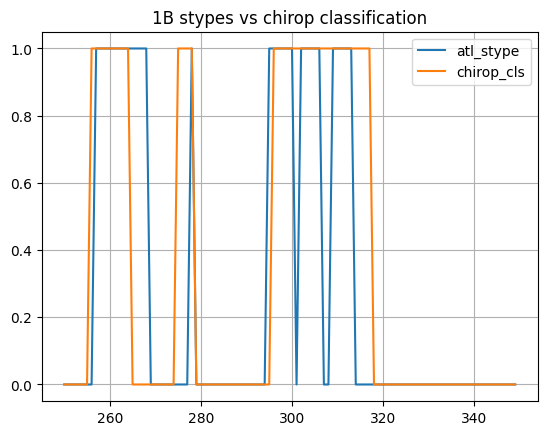

In [122]:
import matplotlib.pyplot as plt

start = 250
end = 350

x = range(start,end)
#chirop
y1 = merged_df['stype'].iloc[start:end]
y2 = merged_df['cls'].iloc[start:end]

# Plot the data

plt.plot(x, y1, label='atl_stype')
plt.plot(x, y2, label='chirop_cls')
plt.legend()

# Plot the data in a scatter plot
plt.title('1B stypes vs chirop classification')
plt.grid(True)
plt.show()